In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import holoviews as hv
from holoviews import opts
import hvplot.xarray
import hvplot.networkx as hvnx

from pathlib import Path
from tqdm.notebook import tqdm

import networkx as nx
import geonetworkx as gnx

import warnings

warnings.filterwarnings('ignore')
hv.extension('bokeh')

In [2]:
from reservoirnetwork.network import ReservoirNetwork

%load_ext autoreload
%autoreload 2

In [3]:
# quick and simple implementation without landlab
river_network_pts_fn = Path('../../data-cumberland/cumberland_rivreg/cumberland_rivreg_pts.geojson')
river_network_fn = Path('../../data-cumberland/cumberland_rivreg/cumberland_rivreg.geojson')

G = gnx.read_geofiles(river_network_pts_fn, river_network_fn, directed=True)
G

{0: Text(-0.8859442747596359, -0.0995647690228677, '0'),
 1: Text(0.2808091238794499, 0.6195502533390057, '1'),
 2: Text(0.14491567205301928, -0.0995235384306362, '2'),
 3: Text(0.5654475562674834, -0.21954637954435494, '3'),
 4: Text(-0.19362725460277042, -0.39491279193500706, '4'),
 5: Text(-0.09134572774264192, -0.7319854555595556, '5'),
 6: Text(0.024943612397657338, 0.31204626234050387, '6'),
 7: Text(0.5909884180072904, 1.0, '7'),
 8: Text(-0.4361871254998533, -0.3860635811870875, '8')}

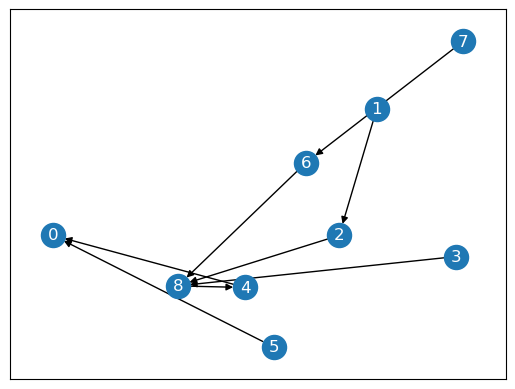

In [4]:
# plot reservoir network

pos = nx.drawing.spring_layout(G)
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_edges(G, pos)
# nx.draw_networkx_labels(G, pos, labels={node:G.nodes[node]['name'] for node in G.nodes},font_color='red')
nx.draw_networkx_labels(G, pos,font_color='white')

In [5]:
# aggregate
def aggregate(ds, frequency='weekly'):
    if frequency == 'weekly':
        resampled = ds.resample(time='1W').mean()
        resampled['dt'] = ds['time'].resample(time='1W').count()
    elif frequency == 'monthly':
        resampled = ds.resample(time='1M').mean()
        resampled['dt'] = ds['time'].resample(time='1M').count()
    elif frequency == 'annual':
        resampled = ds.resample(time='1Y').mean()
        resampled['dt'] = ds['time'].resample(time='1Y').count()
    else:
        raise ValueError(f'frequency {frequency} not supported')
    
    return resampled

def calculate_volumes(
        ds, 
        fluxes=['unregulated_inflow', 'obs_inflow', 'obs_outflow', 'obs_storage_change']
    ):
    """Calculate volume values using flow rates and ∆t

    Args:
        ds (xr.Dataset): Dataset containing flow rates in m3/day
    """
    for flux in fluxes:
        ds[flux] = ds[flux] * ds['dt']
        ds[flux].attrs['units'] = 'm3'
        ds[flux].attrs['long_name'] = f'Volume of {flux}'
        ds[flux].attrs['description'] = f'Volume of {flux} in m3'

    return ds

In [6]:
ds = xr.open_dataset('/water2/pdas47/2023_01_24-river-regulation/data-era5-2010_2021/regulation/regulation_data.insitu.nc')

start_time = pd.to_datetime('2010-10-01')
end_time = pd.to_datetime('2021-09-30')

subset = ds.sel(time=slice(start_time, end_time))
aggregated_subset = calculate_volumes(aggregate(subset, 'monthly'))

if start_time < aggregated_subset.time.min():
    start_time = aggregated_subset.time.min().values
if end_time > aggregated_subset.time.max():
    end_time = aggregated_subset.time.max().values

forcings = xr.Dataset(
    data_vars={
        'theoretical_natural_runoff': aggregated_subset['unregulated_inflow'],
        'storage_change': aggregated_subset['obs_storage_change'],
        'obs_inflow': aggregated_subset['obs_inflow'],
        'obs_outflow': aggregated_subset['obs_outflow'],
        'dt': aggregated_subset['dt']
    }
)

reservoir_network = ReservoirNetwork(G, start_time)

for timestep in tqdm(aggregated_subset.time.values):
    dt = aggregated_subset['dt'].sel(time=timestep).values.item()
    reservoir_network.update(forcings, dt, 'simple_obs_outflow')

reservoir_network.data

  0%|          | 0/132 [00:00<?, ?it/s]

<xarray.Dataset>
Dimensions:                     (node: 9, time: 132)
Coordinates:
  * node                        (node) int64 0 1 2 3 4 5 6 7 8
  * time                        (time) datetime64[ns] 2010-10-31 ... 2021-09-30
Data variables:
    inflow                      (node, time) float64 2.679e+08 5.715e+08 ... 0.0
    outflow                     (node, time) float64 2.738e+08 5.447e+08 ... 0.0
    regulated_runoff            (node, time) float64 2.707e+08 4.18e+08 ... nan
    natural_runoff              (node, time) float64 -2.741e+06 ... 1.351e+08
    theoretical_natural_runoff  (time, node) float64 1.634e+08 ... 7.066e+08
    storage                     (node, time) float64 nan nan nan ... nan nan nan
    storage_change              (time, node) float64 -5.823e+06 ... nan
    regulation                  (node, time) float64 -1.045e+08 ... 7.066e+08
    obs_inflow                  (time, node) float64 5.902e+08 7.171e+03 ... nan
    obs_outflow                 (time, node) float64 5.96e+08 4.272e+06 ... nan
    dt                          (time) int64 31 30 31 31 28 ... 31 30 31 31 30

`reservoir_network.data` contains the model results. Plotting and analysis below.

In [7]:
reservoir_network.data

<xarray.Dataset>
Dimensions:                     (node: 9, time: 132)
Coordinates:
  * node                        (node) int64 0 1 2 3 4 5 6 7 8
  * time                        (time) datetime64[ns] 2010-10-31 ... 2021-09-30
Data variables:
    inflow                      (node, time) float64 2.679e+08 5.715e+08 ... 0.0
    outflow                     (node, time) float64 2.738e+08 5.447e+08 ... 0.0
    regulated_runoff            (node, time) float64 2.707e+08 4.18e+08 ... nan
    natural_runoff              (node, time) float64 -2.741e+06 ... 1.351e+08
    theoretical_natural_runoff  (time, node) float64 1.634e+08 ... 7.066e+08
    storage                     (node, time) float64 nan nan nan ... nan nan nan
    storage_change              (time, node) float64 -5.823e+06 ... nan
    regulation                  (node, time) float64 -1.045e+08 ... 7.066e+08
    obs_inflow                  (time, node) float64 5.902e+08 7.171e+03 ... nan
    obs_outflow                 (time, node) float64 5.96e+08 4.272e+06 ... nan
    dt                          (time) int64 31 30 31 31 28 ... 31 30 31 31 30

In [8]:
ds['obs_outflow'].sel(node=0)

<xarray.DataArray 'obs_outflow' (time: 30316)>
[30316 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 1938-10-01 1938-10-02 ... 2021-09-30
    node     int64 0

In [9]:
reservoir_network.data['obs_outflow'].sel(node=0).hvplot()

:Curve   [time]   (obs_outflow)

In [60]:
reservoir_network.data.to_netcdf('../../data-era5-2010_2021/regulation/regulation_data.insitu.obs_outflow.monthly-2.ERA5.nc')

In [61]:
node = 0

ds = reservoir_network.data
ds['obs_inflow'] = subset['obs_inflow']

ds['inflow'].sel(node=node).hvplot(label='inflow') * ds['obs_inflow'].sel(node=node).hvplot(label='observed') * ds['theoretical_natural_runoff'].sel(node=node).hvplot(label='TNR')

:Overlay
   .Curve.Inflow   :Curve   [time]   (inflow)
   .Curve.Observed :Curve   [time]   (obs_inflow)
   .Curve.TNR      :Curve   [time]   (theoretical_natural_runoff)

In [12]:
from bokeh.models.formatters import NumeralTickFormatter

# plot comparing downstream and upstream nodes
# node = 0
current_node_plot = ds['inflow'].sel(node=node).hvplot(label='inflow').opts(color='#069af3') * ds['obs_inflow'].sel(node=node).hvplot(label='observed').opts(color='k') * ds['theoretical_natural_runoff'].sel(node=node).hvplot(label='TNR').opts(color='green', line_dash='3 3')
current_node_plot = current_node_plot.opts(yformatter=NumeralTickFormatter(format='0.0a'))

upstreams = list(reservoir_network.predecessors(node))

plots = [current_node_plot]
for upstream in upstreams:
    upstream_plot = ds['inflow'].sel(node=upstream).hvplot(label='inflow').opts(color='#a2cffe') * ds['obs_inflow'].sel(node=upstream).hvplot(label='observed').opts(color='k') * ds['theoretical_natural_runoff'].sel(node=upstream).hvplot(label='TNR').opts(color='green', line_dash='dashed')
    upstream_plot *= ds['storage_change'].sel(node=upstream).hvplot(label='storage change').opts(color='gray')
    upstream_plot *= ds['outflow'].sel(node=upstream).hvplot(label='outflow').opts(color='red')
    upstream_plot = upstream_plot.opts(yformatter=NumeralTickFormatter(format='0.0a'), ylabel='inflow [m3]')
    plots.append(upstream_plot)

import panel as pn

hv.Layout(plots).cols(1)

:Layout
   .Overlay.I   :Overlay
      .Curve.Inflow   :Curve   [time]   (inflow)
      .Curve.Observed :Curve   [time]   (obs_inflow)
      .Curve.TNR      :Curve   [time]   (theoretical_natural_runoff)
   .Overlay.II  :Overlay
      .Curve.Inflow         :Curve   [time]   (inflow)
      .Curve.Observed       :Curve   [time]   (obs_inflow)
      .Curve.TNR            :Curve   [time]   (theoretical_natural_runoff)
      .Curve.Storage_change :Curve   [time]   (storage_change)
      .Curve.Outflow        :Curve   [time]   (outflow)
   .Overlay.III :Overlay
      .Curve.Inflow         :Curve   [time]   (inflow)
      .Curve.Observed       :Curve   [time]   (obs_inflow)
      .Curve.TNR            :Curve   [time]   (theoretical_natural_runoff)
      .Curve.Storage_change :Curve   [time]   (storage_change)
      .Curve.Outflow        :Curve   [time]   (outflow)

In [13]:
import scipy.stats as stats

def get_stats(obs, mod):
    corr, corr_p = stats.pearsonr(obs, mod)
    nse = 1 - (np.sum((obs - mod)**2)/np.sum((obs - np.mean(obs))**2))
    nse1 = 1 - (np.sum(np.abs(obs - mod))/np.sum(np.abs(obs - np.mean(obs))))
    rmse = np.sqrt(np.sum((obs-mod)**2)/len(mod))
    norm_rmse = rmse/(np.max(obs) - np.min(obs))
    mae = np.sum(np.abs(mod-obs))/len(mod)
    norm_mae = mae/(np.max(obs) - min(obs))
    kge = 1 - np.sqrt((corr-1)**2 +  (np.std(mod)/np.std(obs) - 1)**2 + (np.mean(mod)/np.mean(obs) - 1)**2) 

    # print({'pearson-r': corr, 'pearson-r p-val': corr_p, 'nse': nse, 'nse1': nse1, 'rmse': rmse, 'norm_rmse': norm_rmse, 'mae': mae, 'norm_mae': norm_mae, 'kge': kge})

    return {'pearson-r': corr, 'pearson-r p-val': corr_p, 'nse': nse, 'nse1': nse1, 'rmse': rmse, 'norm_rmse': norm_rmse, 'mae': mae, 'norm_mae': norm_mae, 'kge': kge}

In [14]:
node = 0

rr_res = ds[['obs_inflow', 'inflow']].sel(node=node).dropna(dim='time')

print('river regulation model results')
get_stats(rr_res['obs_inflow'].data, rr_res['inflow'].data)

river regulation model results


{'pearson-r': 0.8892402307703003,
 'pearson-r p-val': 3.6899871408912963e-39,
 'nse': 0.7668402321143792,
 'nse1': 0.5648635708925687,
 'rmse': 30805723.350669835,
 'norm_rmse': 0.10827387892807296,
 'mae': 21731511.59223077,
 'norm_mae': 0.07638045139459601,
 'kge': 0.8289195017552508}

In [15]:
# node = 0

rr_res = ds[['obs_inflow', 'theoretical_natural_runoff']].sel(node=node).dropna(dim='time')

print('TNR vs. Obs results')
get_stats(rr_res['obs_inflow'].data, rr_res['theoretical_natural_runoff'].data)

TNR vs. Obs results


{'pearson-r': 0.8224801403604757,
 'pearson-r p-val': 1.0193704812133831e-28,
 'nse': 0.5797977966081331,
 'nse1': 0.377815706792486,
 'rmse': 41355546.710564874,
 'norm_rmse': 0.1453536866046875,
 'mae': 31073025.0925619,
 'norm_mae': 0.10921337306393311,
 'kge': 0.7549518521791043}

In [16]:
regulated_runoff_hv = ds['regulated_runoff'].sel(node=node).hvplot(label='regulated_runoff').opts()
natural_runoff_hv = ds['natural_runoff'].sel(node=node).hvplot(label='natural_runoff').opts()
theoretical_natural_runoff_hv = ds['theoretical_natural_runoff'].sel(node=node).hvplot(label='theoretical_natural_runoff').opts()

regulated_runoff_hv * natural_runoff_hv * theoretical_natural_runoff_hv

:Overlay
   .Curve.Regulated_runoff           :Curve   [time]   (regulated_runoff)
   .Curve.Natural_runoff             :Curve   [time]   (natural_runoff)
   .Curve.Theoretical_natural_runoff :Curve   [time]   (theoretical_natural_runoff)

river regulation model results


{'pearson-r': 0.767809626405093,
 'pearson-r p-val': 1.876263319905805e-101,
 'nse': -1.660839785284454,
 'nse1': -0.05303249441256952,
 'rmse': 41341861.23498369,
 'norm_rmse': 0.2559436592661637,
 'mae': 21979820.099372625,
 'norm_mae': 0.13607504399160908,
 'kge': -0.25500646127679194}

In [ ]:
node = 2

rr_res = ds[['obs_inflow', 'regulated_runoff']].sel(node=node).dropna(dim='time')

print('river regulation model results')
get_stats(rr_res['obs_inflow'].data, rr_res['regulated_runoff'].data)

river regulation model results


{'pearson-r': 0.07374028307520886,
 'pearson-r p-val': 3.163007339486722e-10,
 'nse': -0.3283471376888307,
 'nse1': -0.0024450953594090663,
 'rmse': 43576395.257667534,
 'norm_rmse': 0.0794384311717526,
 'mae': 21962145.57125452,
 'norm_mae': 0.04003631734635355,
 'kge': -0.5702984511559932}

In [ ]:
hvds = hv.Dataset(ds['theoretical_natural_runoff'].sel(node=2) - ds['inflow'].sel(node=2), kdims=['time'], vdims=['regulation'])
hvds.to(hv.Curve)
# expected_regulation = ds['theoretical_natural_runoff'].sel(node=2) - ds['inflow'].sel(node=2)

# expected_regulation.hvplot('time')
# # ds['regulation'].sel(node=node).hvplot(label='regulation') * expected_regulation.hvplot(label='expected regulation')

:Curve   [time]   (regulation)